<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/DeepPit_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Mount Google Drive
from google.colab import drive
from pathlib import Path 

ROOT = "/content/drive"    
drive.mount(ROOT)

# Useful paths
PROJ_PATH            = Path(ROOT)/"My Drive/PitProj/"
DICOM_FOLDER         = PROJ_PATH/'fastMRI_brain_DICOM'
MULTICOIL_VAL_FOLDER = PROJ_PATH/'multicoil_val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Viz 

Viz 3d MR expressed as a numpy array:
- Coronal: Axis 0 + Axis 1, Axis 2 = slice index
- Sagittal: Axis 0 + Axis 2, Axis 1 = slice index
- Axial: Axis 1 + Axis 2, Axis 0 = slice index

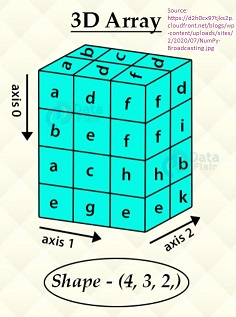

In [21]:
from IPython.display import Image
pic_path = f"{PROJ_PATH}/pics/np_axes_illustration.jpg"
Image(pic_path, width=400, height=200)

In [44]:
{"a":1}["a"]

1

In [100]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec

def viz_ras(np_arr, slices, view, nrows = 1, ncols = 1, wspace=0.0, hspace=0.0, fig_mult=1):
  n_slices = len(slices)
  if nrows * ncols == 1: nrows, n_cols = 1, n_slices

  fixed_axis = {"axial": 0, "sagittal":1, "coronal":2}[view]

  # from SO: https://stackoverflow.com/questions/41071947/how-to-remove-the-space-between-subplots-in-matplotlib-pyplot
  fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
  gs  = gridspec.GridSpec(nrows, ncols,
    wspace=wspace, hspace=hspace, 
    top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
    left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 

  index = 0
  for row in range(nrows):
    for col in range(ncols):
      ax = plt.subplot(gs[row,col])
      ax.imshow(np.take(np_arr, slices[index], fixed_axis))
      ax.set_title(f"Slice {index}")
      index += 1
  
  plt.show()
  # return plt

# Test

### fastMRI 

H5 files

In [34]:
%matplotlib inline

import os
import h5py

# choose a h5 file
h5_folder = f"{PROJ_PATH}/multicoil_val"
h5_files = os.listdir(h5_folder)
print(f"{len(h5_files)} files:", *h5_files, sep="\n")

# get the underlying MR
np_arr = hf['reconstruction_rss'][()]
print("MR shape: ", np_arr.shape)

8 files:
file_brain_AXFLAIR_200_6002471.h5
file_brain_AXFLAIR_200_6002462.h5
file_brain_AXT1POST_200_6001976.h5
file_brain_AXT1POST_200_6001979.h5
file_brain_AXT1PRE_200_6002087.h5
file_brain_AXT1PRE_200_6002079.h5
file_brain_AXT1_201_6002725.h5
file_brain_AXT1_201_6002736.h5
MR shape:  (16, 320, 320)


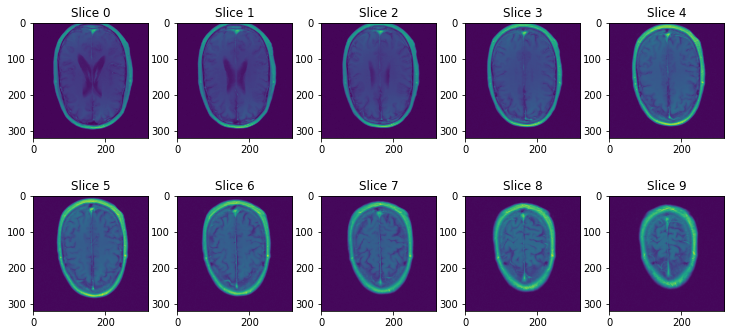

In [101]:
# viz
viz_ras(np_arr, slices=range(0,10), view="axial", nrows=2, ncols=5, hspace=0.5, fig_mult=2)

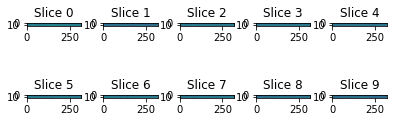

In [105]:
viz_ras(np_arr, slices=range(0,10), view="coronal", nrows=2, ncols=5, fig_mult=1, wspace=0.4)

### Nifti

In [110]:
%%capture

# pip install 
!pip install pydicom
!pip install meshio
!pip install nibabel
!pip install nilearn

In [113]:
# import
import pydicom as pyd
import meshio
import nibabel as nib
import nilearn as nil

# choose a nii file
nii_folder = f"{PROJ_PATH}/play"
nii_file = f"{nii_folder}/ABIDE_50454_MRI_MP-RAGE_br_raw_20120830175600888_S164683_I328693 (1).nii"

# SEG_PATH = NIFTI_FOLDER/"Segmentation.obj"

# get the underlying MR in RAS+ = canonical coords
nii_arr = nib.load(nii_file)
print("NifTi coord system (original)", nib.aff2axcodes(nii_arr.affine), sep="\n")

# Convert to RAS+ = canonical coords
np_arr = nib.as_closest_canonical(nii_arr).get_fdata(dtype=np.float32)
print("MR shape: ", np_arr.shape, " (axial, sagittal, coronal)")

NifTi coord system (original)
('L', 'A', 'S')
MR shape:  (160, 480, 512)  (axial, sagittal, coronal)


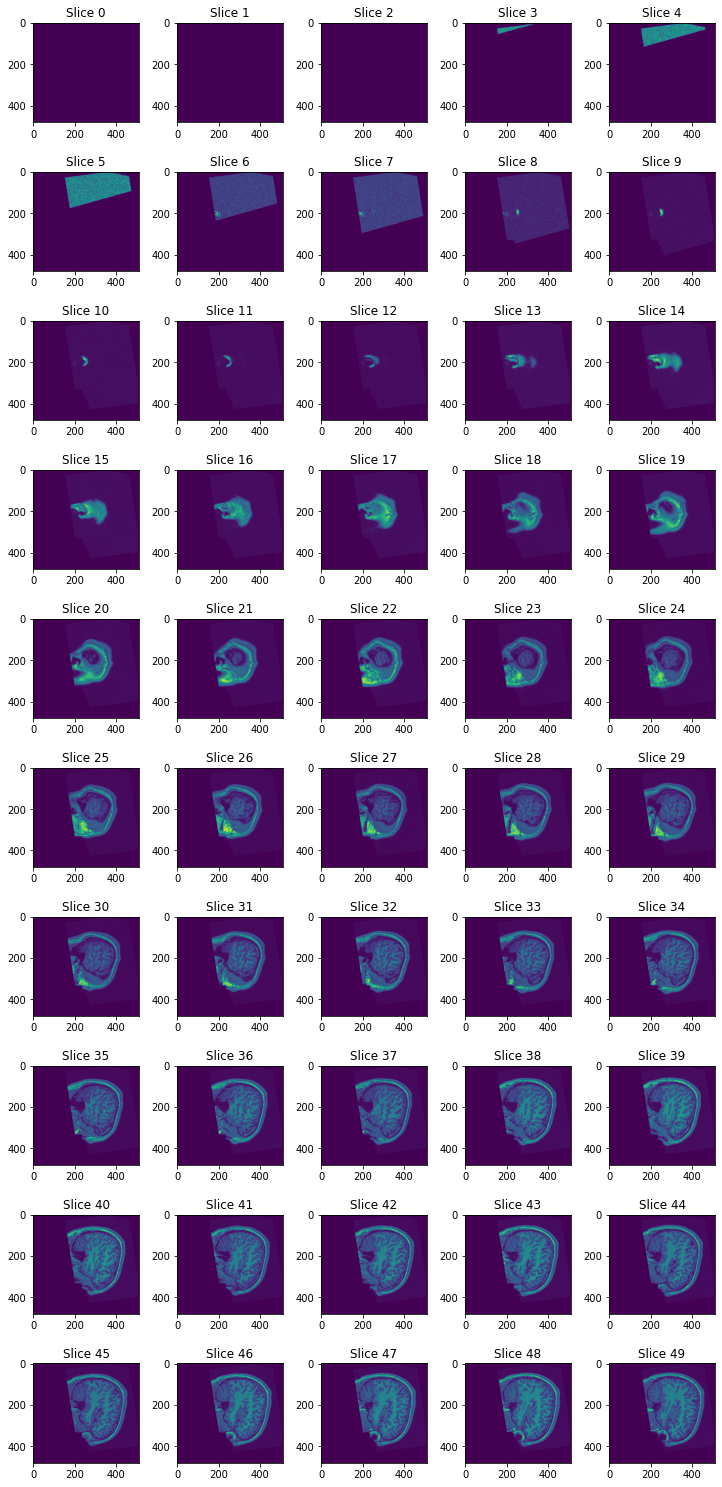

In [115]:
# viz
viz_ras(np_arr, slices=range(0,50), view="axial", nrows=10, ncols=5, hspace=0.5, fig_mult=2)

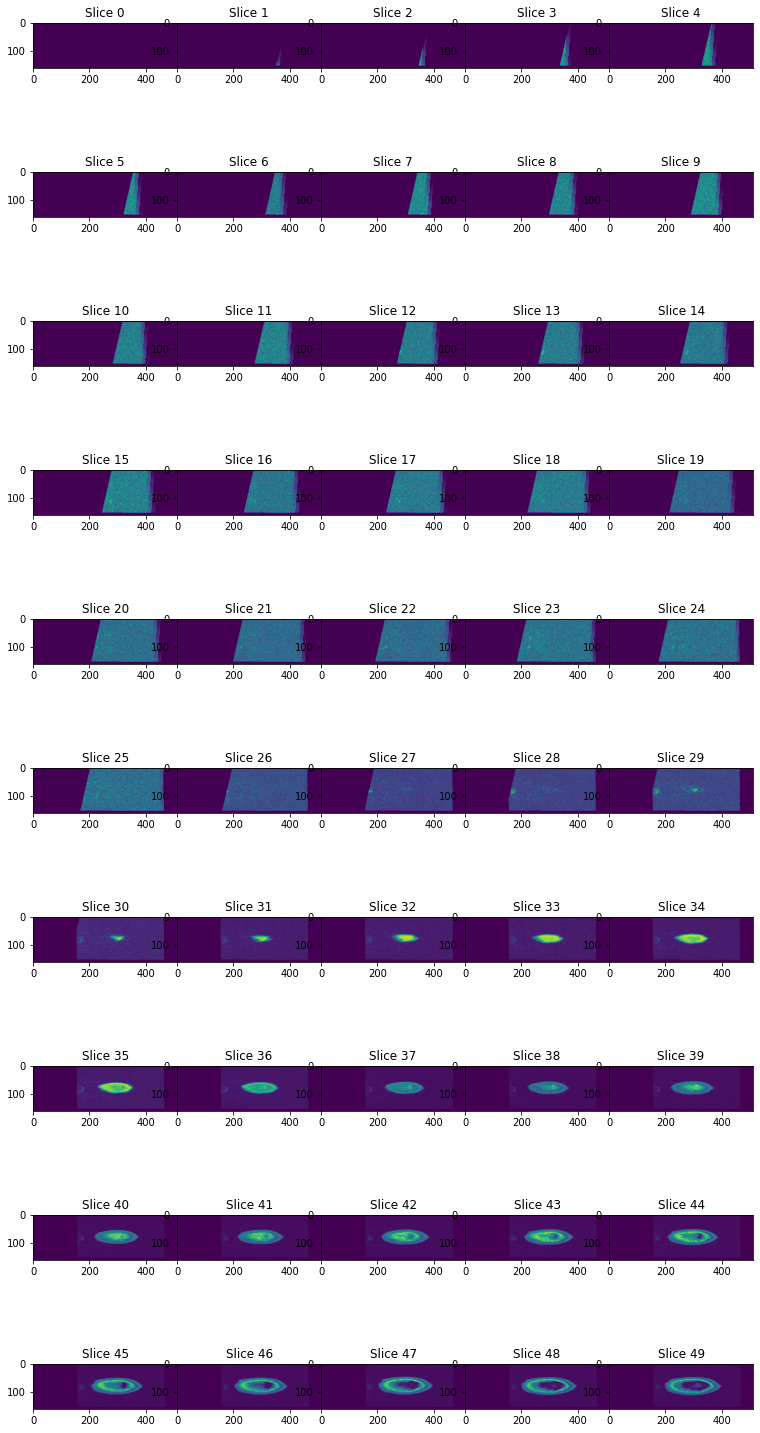

In [116]:
# viz
viz_ras(np_arr, slices=range(0,50), view="sagittal", nrows=10, ncols=5, hspace=0.5, fig_mult=2)

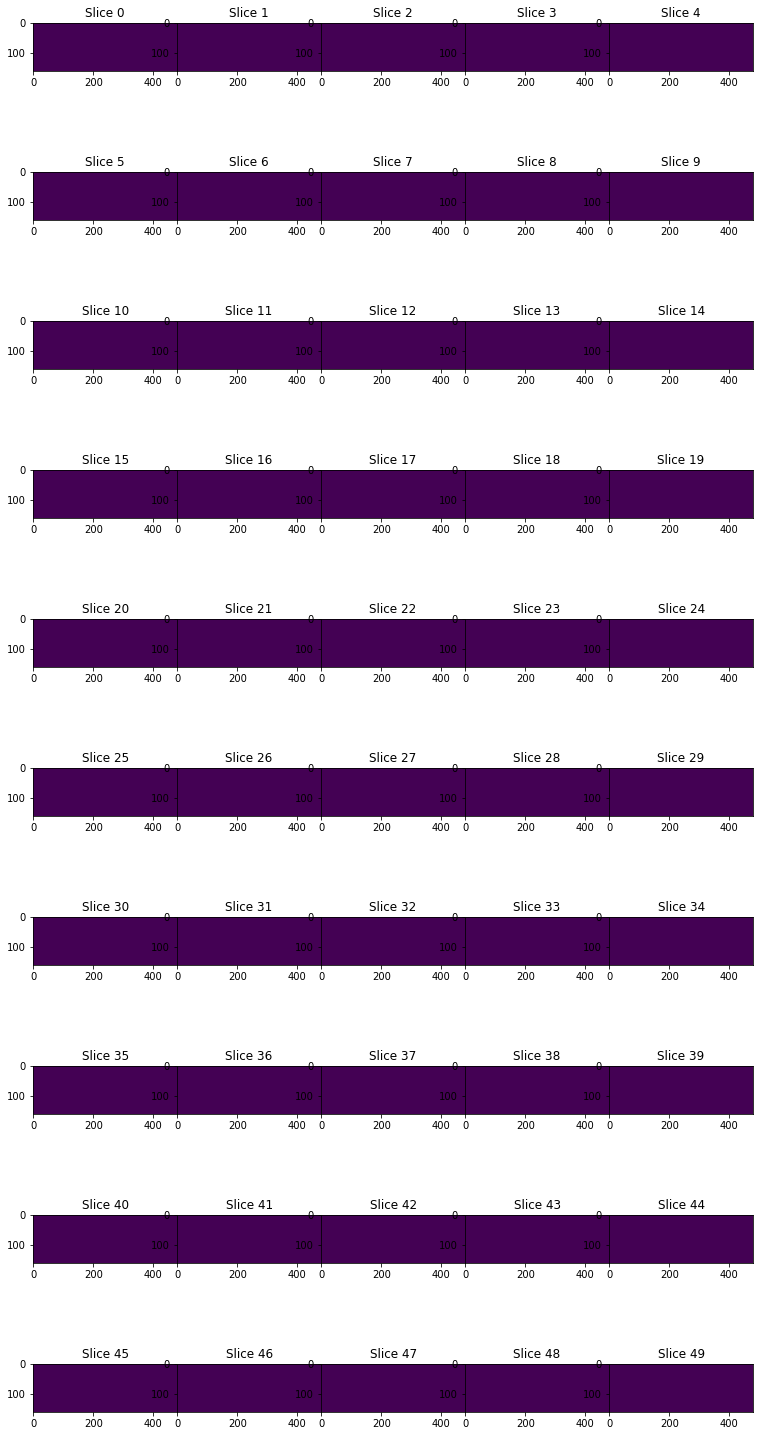

In [117]:
# viz
viz_ras(np_arr, slices=range(0,50), view="coronal", nrows=10, ncols=5, hspace=0.5, fig_mult=2)

In [ ]:
# MR coordinate systems: https://www.slicer.org/wiki/Coordinate_systems
# MR Image coordinate system:
# ijk coords for a cube/rectangular prism: i is left to right, j = top to bottom, k = front to back (ie slice number)

# Numpy coordinate system: https://www.pythoninformer.com/python-libraries/numpy/index-and-slice/
# ijk coords for a cube/rectangular prism: k is left to right, j = top to bottom, i = front to back (ie slice number)

def mr_3d_bounding_box_crop(mr_3d, top_left, bottom_right):
  """ 
  input: 3d array of MR slices, ijk 3-tuple of top left and bottom right crop location
  output: 3d array of MR slices cropped from top left to bottom right 
  """
  i_start, j_start, k_start = top_left
  i_end, j_end, k_end       = bottom_right
  return mr_3d[k_start:k_end, j_start:j_end, i_start:i_end]